# Solving Ordinary Differential Equations in R with deSolve: Example

## Contents

1. [Population growth: exponential](#exppop)  
2. [The ode() function](#ode)  
2.1 [ode() inputs](#ode_in)  
2.2 [ode() outputs](#ode_out)  
3. [Population growth: logistic](#logpop)  
4. [Summary](#summary)  
5. [Useful programming hints](#tips)  
5.1 [Where functions find values associated with names: Scope](#scope)  
5.2 [Less cluttered code: with()](#with)
6. [Further work: calculate manually](#manual)  
  

In [2]:
# If you are working in RStudio, you will need to install if you haven't already:
# install.packages("ggplot2")
# install.packages("deSolve")

# Run the library() function to load these packages
library(ggplot2)
library(deSolve)


To model processes such as population growth, or the spread of infection in a population for example, we often consider how the relevant variables change over time. This means we need to look at **differential equations**.

## 1. Population growth: exponential<a name="exppop"></a>

The variable of interest in this case, is the size of the population: call this $N$.  

We want to model $N$ as it changes over time: $dN/dt$.  

For a very simple population, growth (especially initially) can be modelled as **exponential**.

Imagine a very simple population of bacteria growing in a large flask with good food supply (and removal of waste). As long as each bacterium divides at least once (so one cell becomes two viable daughter cells), the population will grow. In fact the population's growth is proportional to the population size, which we can write down in mathematical terms as<a name="expfun"></a>

$$
\frac{dN}{dt} = \alpha N
$$

This is an Ordinary Differential Equation, or ODE.

We refer to N as a *state variable*; its value represents the state of the system at a given time. $\alpha$ (alpha) is a *parameter*. 

Notice here, we're ignoring some of the realistic constraints on population size: for example, the size of the flask, and the amount of food available. For now, we're only looking at the initial population growth, but later we'll bring constraints in as well. 

You'll now see how to solve this equation using R, for a given value of $\alpha$. This is a simple example that will help you get familiar with the ODE solvers in R. You will then use these same techniques in the specialisation, when you come to modelling infectious diseases.

## 2. The ```ode()``` function<a name="ode"></a>

To solve the differential equation, you can use a function called ```ode()```, in the ```deSolve``` package.

The use of this function looks like this - it takes four inputs which we will define in a moment:

In [ ]:
require(deSolve)

result <- ode(      y = state_vars  # initial state variables: state variables at first timepoint
              , times = times       # a vector of timepoints 
              ,  func = exp_pop_fn  # the differential equation itself, in the form of a function
              , parms = parms)      # parameters for the equation in func

# Now to see what each input actually is.

### 2.1 ```ode()``` inputs <a name="ode_in"></a>
Each argument ```ode()``` needs is explained in the help file. Run this and look at the first four arguments:

In [ ]:
?ode

(in Jupyter notebooks, this will load the help file in a new browser tab/window)  

 ```y``` must contain the initial state values. In our simple example, we only have $N$. We start with 1 bacterium, so our initial $N = 1$  
 ```times```contains the sequence of times for which we want to know the output. The first timepoint is the initial timepoint, corresponding to our initial state values.  
 ```func``` is our differential equation, defined *as an R function*. The help file shows how to define it yourself. (You can also use pre-defined equations.)  
 ```parms``` are the parameters for the equation in ```func```.  

The ```ode()``` function has a number of other arguments but we don't have to define them all -  ```method```, for example, has a default.

In [2]:
# y
state_vars  <- c(N = 1) # a vector with a named element

# times
times       <- seq(0, 40, by = 0.5) # the shorter the timesteps, the more accurate a solution

# func: a function 
exp_pop_fn <- function(time, state, parameters) { 
                                      
  N <- state['N'] # within this function, the state variables - in this case, just N
  
  dN <- parameters['alpha'] * N  # alpha is extracted from the 'parameters' argument
                                 # this argument gets fed in by the ode() function
                                 # specify when running ode()
  
  return(list(c(dN))) # tell the function what to return: 
                      # here, we need the calculated dN value, in a list.
  
  # if you have more than one state variable to calculate
  # tell the function to return derivatives in the same order
  # as you entered them (in the `state` argument)
                      
} 

# Remember that this function is an argument into another function; it doesn't do a lot by itself.
# The inputs come from running the ode() function, the output goes back into the ode() function.

# parms
parms <- c(alpha = log(2)) # alpha has been chosen so the population doubles each timestep

parms['alpha'] # you can see "parms" is a vector with one named element, alpha.
               # this argument 'parms' gets fed, by ode(), into the function that you specify to use as func
               # so it needs to contain whatever variables that function is expecting.

# For this example:
result <- ode(y = state_vars         # contains initial N
              , times = times        # the vector of timepoints 
              , func = exp_pop_fn    # the exponential equation, written as a function
              , parms = parms)       # parameters for the exponential equation: here, just alpha


alpha 
0.6931472

* Look at the function ```exp_pop_fn()``` defined in the cell above; compare the line ```dN <- parameters['alpha']*N``` to the [equation](#expfun) you've seen above.

### 2.2 ```ode()``` output<a name="ode_out"></a>
Looking at the help file tells you the output value (under the heading "Value") is a 'deSolve' object, which as you might tell from the name, is specific to the deSolve package. If we want to do things such as plot the output, it's more straightforward if we turn this into a dataframe. Luckily, the ```as.data.frame()``` function can handle this, and it keeps the names of the columns.

time,N
<dbl>,<dbl>
0.0,1.000000
0.5,1.414216
1.0,2.000003
1.5,2.828433
2.0,4.000009
2.5,5.656869


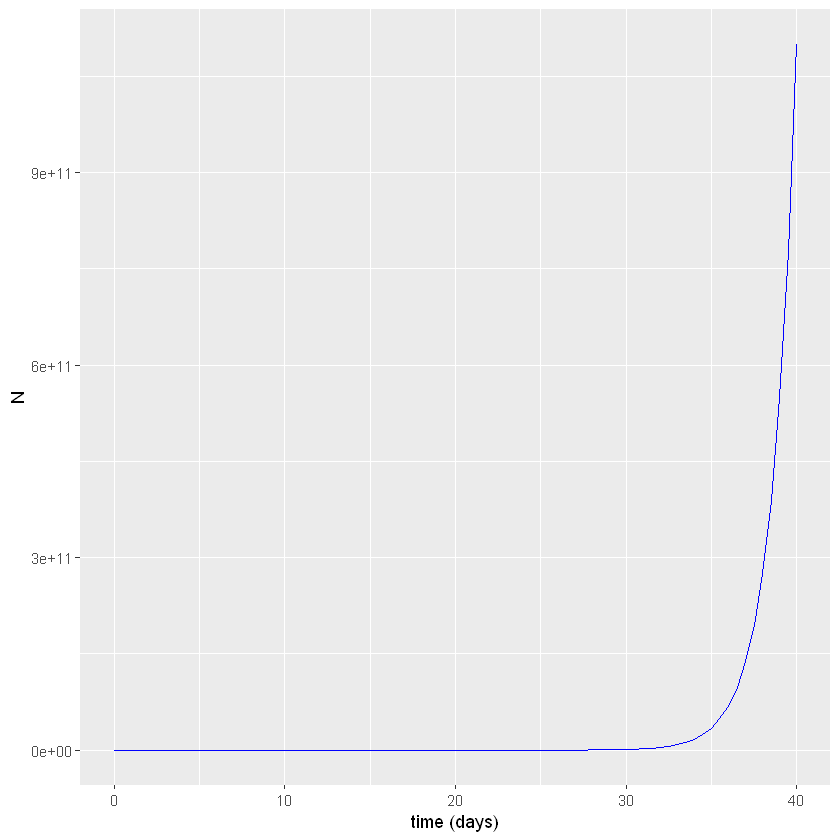

In [3]:
head(as.data.frame(result)) # shows the first few lines of the results

result <- as.data.frame(result) # turn the output into a data.frame

# use ggplot to create a graph of times against the population size N
require(ggplot2) # if

expplot <- ggplot(data = result)
expplot <- expplot + geom_line(aes(x = time, y = N)
                               ,  colour = "blue")
expplot <- expplot + labs(x = "time (days)")
expplot # shows the graph

## 3. More realistic: logistic growth <a name="logpop"></a>

Let's make this closer to reality, and take into account the fact that populations cannot increase forever in a limited space with limited resources. In ecology we model this using what is known as a 'carrying capacity', called K. As the population size comes close to K, then the rate of growth slows down. The population equation we want to solve for $dN/dt$ with a carrying capacity $K$ is the **logistic growth** equation:

$$
\frac{dN}{dt} = \alpha N\left(1 - \frac{N}{K}\right)
$$

We'll need to make this into a suitable function for ```func```:

In [ ]:
logistic_fn <- function(t, state, parameters) { # You'll need a K in the parameters argument

        N  <- state['N']  # still our only state variable
    
        dN <- parameters['alpha'] * N * (1 - (N / parameters['K'])) 
        # this line represents the differential equation

        return(list(c(dN)))

        }


Assign the $K$ parameter, run ode() with your new logistic function, and plot the output:

In [ ]:
parms['K'] <- 1000000 
# the vector 'parms' now includes an element named K, assigned the value 1000000 to represent carrying capacity

result_K <- ode(    y = state_vars   # still only contains initial N
              , times = times        # the vector of timepoints we already have
              ,  func = logistic_fn  # the logistic equation function
              , parms = parms)       # parms now includes K

result_K <- as.data.frame(result_K)

#check the output, and plot
tail(result_K) # to view the last 6 rows; note that N approaches K

logplot <- ggplot(data = result_K)
logplot <- logplot + geom_line(aes(x = time, y = N)
                               ,  colour = "blue")
logplot <- logplot + labs(x = "time (days)")
logplot


## 4. Summary<a name="summary"></a>

So as long as you can:  

* express what's happening to a variable by using a differential equation  
* identify what the parameters of the equation are
* decide what your starting values are for the state variables
  
you can:  

* write a function to represent the differential equation
* create (named) vectors or lists to hold the values for the parameters and state variables

and then, along with  

* an ordered vector of timepoints  
  
you input these into ```ode()```, to solve your differential equation and output the variable(s) of interest, at each of those timepoints.


For a quick introduction to exponential and logistic equations for population growth, visit:
<https://www.nature.com/scitable/knowledge/library/how-populations-grow-the-exponential-and-logistic-13240157>

For more detailed references on the ```deSolve``` package, try searching for deSolve vignettes
<https://cran.r-project.org/web/packages/deSolve/vignettes/deSolve.pdf>

## 5. Programming tips and points to remember<a name="tips"></a>  

Make use of the ```names``` attributes: either use  
    * lists   - refer to elements using ```$```: ```list_name$element_name```  
    * vectors - refer to elements using ```[]``` notation: ```vector_name['element_name']```  
depending on the situation.

Remember that lists can contain a mixture of types and structures, and vectors contain only one data type, as well as the differences in how you reference elements.  

Whatever you do, use comments and consistency  
 - *look back at your code to see if you can understand each part*  
 

### 5.1 Where functions find values associated with names: Scope<a name="scope"></a>  

A common source of error when writing functions, especially when there are functions-within-functions, is that you might find that either your function returns an error, or returns a value you didn't expect. This could be due to misnaming of variables or arguments. You might find that following working examples is helpful for avoiding these, but if you want to understand more about where functions find values, read this section.

Arguments are given their own names within the *environment*, or the *scope* of the function.
You give names to the variables that will contain your arguments, and you tell the function what each argument is, or give them to the function in the order it expects. The function then refers to each argument to the name it has internally.  

For an explanation of scope, try the following references:  
A general introduction to the concept:   <https://en.wikiversity.org/wiki/Introduction_to_Programming/Scope>

How R finds what values are associated with names:  
<https://adv-r.hadley.nz/functions.html#lexical-scoping>

Also R-specific, more technical:  
<https://www.datamentor.io/r-programming/environment-scope/>

An explanation using another language, Python:  
<https://pythonbasics.org/scope/>

This is also taken advantage of if you use ```with()``` 

### 5.2 Less cluttered code: ```with()```<a name="with"></a>  

For more complex functions, you might find your code is getting cluttered or that you have used lots of lines to assign values within the function.

* You can make use of ```as.list()``` and ```with()``` so you can write sections of code referring to named elements directly. It's good to note this as an option. Different people will have different preferences as to whether this is used.  

The differential equation is more complicated for the logistic function than it was for the exponential function, so one option is to remove the necessity for referring to elements inside vectors and lists with the full notation:  

Using ```with()``` and ```as.list()``` means we can refer to all the required elements by their names only:   
```as.list()``` tells R to create a list object from what you give it  
```with()``` tells R to look "inside" the object you give it to find objects you refer to: looking inside the [scope](#scope) of the object.  

In [ ]:
with(as.list(c(state_vars, parms)), {   # give with() a list made of state_vars and parms
    print(alpha)                        # to find anything referenced within the curly brackets,
    print(N)                            # R looks for names within the object given to with()
})  

So we can use this to make the function code less cluttered.

In [ ]:
# clearer code for the logistic function:

logistic_fn <- function(t, state, parameters) { # You'll need a K in the parameters argument

    with(as.list(c(state, parameters)), {           
        
        # you can now just refer to N directly, so no need to assign
        
        dN <- alpha * N * (1 - (N / K))  # this line represents the differential equation
        
        return(list(c(dN)))
    })

        
    }


You may prefer this, or you may prefer to assign your variables within the function - or even continue to refer to them in full. Whatever you do, clarity and consistency will help both you and anyone else who needs to work with your code. 

## 6. Further work: calculate manually<a name="manual"></a>

For simple examples, we can solve the differential equations by hand, and confirm that we get the same results as ```ode()```.
For exponential growth:

$$\frac{dN}{dt} = \alpha N \quad therefore \quad N = N_0 e^{\alpha t} $$

In [ ]:

exp(parms['alpha']) 
#  alpha was chosen so that at each whole timestep, the population doubles

t <- seq(1, 40, by = 1) # vector of times at which to calculate the population size
# these don't have to be the same as the timepoints as the ode() output was generated at

N_calc <- state_vars['N'] * 2^t # every day, the population doubles

# R automatically vectorises this expression, applying it to each element of 't' in turn, to create vector N_calc
# N_calc should be the same length as t. Make them into a dataframe
pop_df <- data.frame(times = t, N = N_calc)

require(ggplot2)
expplot  <- expplot + 
            geom_point(data = pop_df,    # specify different dataframe here
                        aes(y = N_calc, x = t)
                      , shape = 4
                      , size = 2
                      , colour = "red")  

expplot

We directly calculate population size at a series of time points, and can see that it fits the curve we generated using ```ode()```.